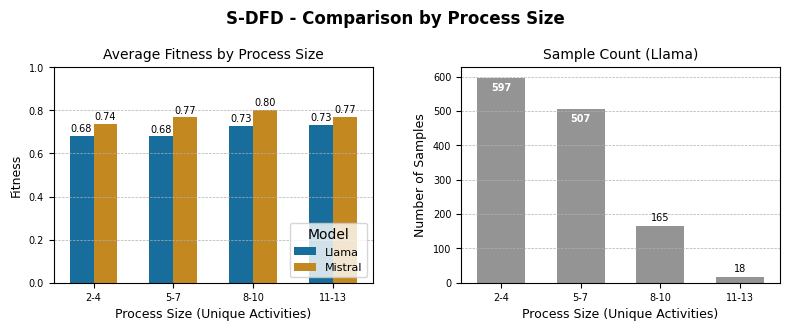

In [ ]:
# plot: S-DFD - Comparison by Process Size

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

df_a = pd.read_csv("") # logs_<>.csv file for dfg generation Llama
df_b = pd.read_csv("") # logs_<>.csv file for dfg generation Mistral

for df in [df_a, df_b]:
    df["unique_activities"] = df["unique_activities"].apply(ast.literal_eval)
    df["num_unique_activities"] = df["unique_activities"].apply(len)
    df["process_size_bucket"] = pd.cut(
        df["num_unique_activities"],
        bins=[2, 4, 7, 10, 13],
        labels=["2-4", "5-7", "8-10", "11-13"]
    )

fitness_records = []

for model_name, df in [("Llama", df_a), ("Mistral", df_b)]:
    for bucket in df["process_size_bucket"].cat.categories:
        group = df[df["process_size_bucket"] == bucket]
        if len(group) > 0:
            avg_fitness = group["fitness"].mean()
        else:
            avg_fitness = float("nan")
        fitness_records.append({
            "Model": model_name,
            "process_size_bucket": bucket,
            "avg_fitness": avg_fitness,
            "count": len(group)
        })

fitness_df = pd.DataFrame(fitness_records)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.2))
fig.suptitle("S-DFD - Comparison by Process Size", fontsize=12, weight="bold", y=1.02)
pastel_palette = sns.color_palette("colorblind")

# --- Left plot: Average Fitness comparison ---
sns.barplot(data=fitness_df, x="process_size_bucket", y="avg_fitness", hue="Model", 
            ax=ax1, width=0.6, palette=pastel_palette[:2])  # Use 2 pastel colors

for p in ax1.patches:
    height = p.get_height()
    if not pd.isna(height) and height > 0:
        ax1.annotate(f"{height:.2f}",
                     (p.get_x() + p.get_width() / 2., height + 0.01),
                     ha='center', va='bottom', fontsize=7)

ax1.set_title("Average Fitness by Process Size", fontsize=10)
ax1.set_ylabel("Fitness", fontsize=9)
ax1.set_xlabel("Process Size (Unique Activities)", fontsize=9)
ax1.set_ylim(0, 1)
ax1.grid(axis="y", linestyle="--", linewidth=0.5)
ax1.tick_params(axis='both', labelsize=7)
ax1.legend(title="Model", fontsize=8, loc="lower right")

# --- Right plot: Sample Count ---
sns.barplot(data=fitness_df[fitness_df["Model"] == "Llama"], 
            x="process_size_bucket", y="count", ax=ax2, color=pastel_palette[7], width=0.6)

for p in ax2.patches:
    height = p.get_height()
    if not pd.isna(height) and height >= 0:
        if height > 500:
            ax2.annotate(f"{int(height)}",
                         (p.get_x() + p.get_width() / 2., height - 30),
                         ha='center', va='center', fontsize=7, color="white", weight="bold")
        else:
            ax2.annotate(f"{int(height)}",
                         (p.get_x() + p.get_width() / 2., height + 10),
                         ha='center', va='bottom', fontsize=7, color="black")

ax2.set_title("Sample Count (Llama)", fontsize=10)
ax2.set_ylabel("Number of Samples", fontsize=9)
ax2.set_xlabel("Process Size (Unique Activities)", fontsize=9)
ax2.grid(axis="y", linestyle="--", linewidth=0.5)
ax2.tick_params(axis='both', labelsize=7)

plt.tight_layout(rect=[0, 0, 1, 1.05], w_pad=3)
plt.show()

In [ ]:
import pandas as pd
import ast
import networkx as nx

df_llama = pd.read_csv("") # logs_<>.csv file for dfg generation Llama
df_mistral = pd.read_csv("") # logs_<>.csv file for dfg generation Mistral

# Parse the DFG columns
df_llama["true_label"] = df_llama["true_label"].apply(ast.literal_eval)
df_llama["prediction"] = df_llama["prediction"].apply(ast.literal_eval)
df_llama["unique_activities"] = df_llama["unique_activities"].apply(ast.literal_eval)

df_mistral["true_label"] = df_mistral["true_label"].apply(ast.literal_eval)
df_mistral["prediction"] = df_mistral["prediction"].apply(ast.literal_eval)
df_mistral["unique_activities"] = df_mistral["unique_activities"].apply(ast.literal_eval)

def build_graph(edges):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G

def is_parallel(edge_set, a, b):
    return (a, b) in edge_set and (b, a) in edge_set

def has_deadlock(G):
    """Check if any nodes are unreachable from start nodes."""
    if G.number_of_nodes() == 0:
        return False

    start_nodes = [n for n in G.nodes if G.in_degree(n) == 0]

    if not start_nodes:
        return False  # No start nodes = other error

    reachable = set()
    for start in start_nodes:
        reachable |= nx.descendants(G, start)
        reachable.add(start)

    return len(reachable) < len(G.nodes)

def detect_start_end_issues(G):
    """Detect unclear start/end and locked circular process."""
    start_nodes = [n for n in G.nodes if G.in_degree(n) == 0]
    end_nodes = [n for n in G.nodes if G.out_degree(n) == 0]

    locked_process = int(len(start_nodes) == 0 and len(end_nodes) == 0)
    
    unclear_start = int((len(start_nodes) != 1) and (len(start_nodes) != 0)) if not locked_process else 0
    unclear_end = int((len(end_nodes) != 1) and (len(end_nodes) != 0)) if not locked_process else 0

    return unclear_start, unclear_end, locked_process

def has_unused_activities(G, activities):
    """Check if there are activities not used in the graph."""
    used_activities = set(G.nodes)
    return not set(activities).issubset(used_activities)

def has_direct_order_flip(true_set, pred_set):
    """Check if a direct order is reversed incorrectly."""
    for (a, b) in true_set:
        if (b, a) in pred_set:
            # If (a, b) is expected but (b, a) exists, and NOT both ways
            if not ((a, b) in pred_set and (b, a) in pred_set):
                return True
    return False

# --- Main Analysis ---
llama_error_stats = []

for idx, row in df_llama.iterrows():
    if row["fitness"] == 1.0:
        continue

    true_edges = [tuple(edge) for edge in row["true_label"]]
    pred_edges = [tuple(edge) for edge in row["prediction"]]

    true_set = set(true_edges)
    pred_set = set(pred_edges)

    missing_edges = true_set - pred_set
    extra_edges = pred_set - true_set

    G_true = build_graph(true_edges)
    G_pred = build_graph(pred_edges)

    # --- Missing / Extra parallelism ---
    missing_parallel_detected = any(
        is_parallel(true_set, a, b) for a, b in missing_edges
    )

    extra_parallel_detected = any(
        is_parallel(pred_set, a, b) for a, b in extra_edges
    )

    # --- Deadlock & Start/End Problems ---
    deadlock_detected = has_deadlock(G_pred)
    unclear_start_detected, unclear_end_detected, locked_process_detected = detect_start_end_issues(G_pred)

    # --- Other patterns ---
    unused_activities_detected = has_unused_activities(G_pred, row["unique_activities"])
    direct_order_flip_detected = has_direct_order_flip(true_set, pred_set)

    has_missing_parallel = int(missing_parallel_detected)
    has_extra_parallel = int(extra_parallel_detected)

    llama_error_stats.append({
        "id": row["id"],
        "has_missing_parallelism": has_missing_parallel,
        "has_extra_parallelism": has_extra_parallel,
        "has_deadlock": int(deadlock_detected),
        "unclear_start": unclear_start_detected,
        "unclear_end": unclear_end_detected,
        "locked_process": locked_process_detected,
        "has_unused_activities": int(unused_activities_detected),
        "has_direct_order_flip": int(direct_order_flip_detected),
        "fitness": row["fitness"]
    })
llama_error_df = pd.DataFrame(llama_error_stats)


mistral_error_stats = []
for idx, row in df_mistral.iterrows():
    if row["fitness"] == 1.0:
        continue

    true_edges = [tuple(edge) for edge in row["true_label"]]
    pred_edges = [tuple(edge) for edge in row["prediction"]]

    true_set = set(true_edges)
    pred_set = set(pred_edges)

    missing_edges = true_set - pred_set
    extra_edges = pred_set - true_set

    # Build graphs
    G_true = build_graph(true_edges)
    G_pred = build_graph(pred_edges)

    # --- Missing / Extra parallelism ---
    missing_parallel_detected = any(
        is_parallel(true_set, a, b) for a, b in missing_edges
    )

    extra_parallel_detected = any(
        is_parallel(pred_set, a, b) for a, b in extra_edges
    )

    # --- Deadlock & Start/End Problems ---
    deadlock_detected = has_deadlock(G_pred)
    unclear_start_detected, unclear_end_detected, locked_process_detected = detect_start_end_issues(G_pred)

    # --- Other patterns ---
    unused_activities_detected = has_unused_activities(G_pred, row["unique_activities"])
    direct_order_flip_detected = has_direct_order_flip(true_set, pred_set)

    has_missing_parallel = int(missing_parallel_detected)
    has_extra_parallel = int(extra_parallel_detected)

    mistral_error_stats.append({
        "id": row["id"],
        "has_missing_parallelism": has_missing_parallel,
        "has_extra_parallelism": has_extra_parallel,
        "has_deadlock": int(deadlock_detected),
        "unclear_start": unclear_start_detected,
        "unclear_end": unclear_end_detected,
        "locked_process": locked_process_detected,
        "has_unused_activities": int(unused_activities_detected),
        "has_direct_order_flip": int(direct_order_flip_detected),
        "fitness": row["fitness"]
    })
mistral_error_df = pd.DataFrame(mistral_error_stats)


/tmp/ipykernel_3280323/3213328471.py:53: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(data=error_comparison_df, x="Error Type", y="Percentage", hue="Model", palette=pastel_palette)


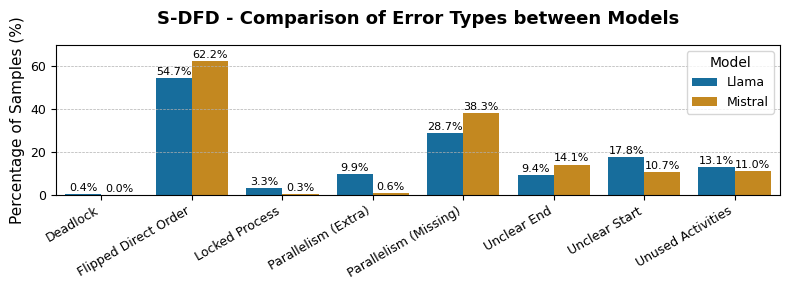

In [ ]:
# plot: S-DFD - Comparison of Error Types between Models

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pastel_palette = sns.color_palette("colorblind")

error_columns = [
    'has_missing_parallelism',
    'has_extra_parallelism',
    'has_deadlock',
    'unclear_start',
    'unclear_end',
    'locked_process',
    'has_unused_activities',
    'has_direct_order_flip'
]

pretty_labels = {
    'has_missing_parallelism': "Parallelism (Missing)",
    'has_extra_parallelism': "Parallelism (Extra)",
    'has_deadlock': "Deadlock",
    'unclear_start': "Unclear Start",
    'unclear_end': "Unclear End",
    'locked_process': "Locked Process",
    'has_unused_activities': "Unused Activities",
    'has_direct_order_flip': "Flipped Direct Order"
}

def compute_error_percentages(df, model_name):
    percentages = (df[error_columns].sum() / len(df)) * 100
    percentages = percentages.rename(pretty_labels)
    return pd.DataFrame({
        "Error Type": percentages.index,
        "Percentage": percentages.values,
        "Model": model_name
    })

llama_errors = compute_error_percentages(llama_error_df, "Llama")
mistral_errors = compute_error_percentages(mistral_error_df, "Mistral")

error_comparison_df = pd.concat([llama_errors, mistral_errors])
error_comparison_df = error_comparison_df.sort_values("Error Type")

plt.figure(figsize=(8, 3))
sns.barplot(data=error_comparison_df, x="Error Type", y="Percentage", hue="Model", palette=pastel_palette)

for idx, row in error_comparison_df.iterrows():
    error = row["Error Type"]
    model = row["Model"]
    percent = row["Percentage"]

    bar_idx = list(error_comparison_df["Error Type"].unique()).index(error)
    group_offset = -0.2 if model == "Llama" else 0.2  # adjust based on bar width/hue

    plt.text(bar_idx + group_offset, percent + 0.5, f"{percent:.1f}%", 
             ha='center', va='bottom', fontsize=8,
             color="black", fontstyle="normal" if percent>0 else "normal")

plt.title("S-DFD - Comparison of Error Types between Models", fontsize=13, weight="bold", pad=15)
plt.ylabel("Percentage of Samples (%)", fontsize=11)
plt.xlabel("")
plt.xticks(rotation=30, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title="Model", fontsize=9)

plt.ylim(0, 70)

plt.tight_layout()
plt.show()